# Лінійна регресія

Працюємо з набором даних про рівень щастя у країнах за 2019 рік. Він доступний на Kaggle [змагання](https://www.kaggle.com/unsdsn/world-happiness?select=2019.csv).

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import operator 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline

1. Зчитуємо дані за допомогою pandas у змінну `df`.

In [54]:
df = pd.read_csv(r"C:\Data\2019.csv")
print(df)

     Overall rank         Country or region  Score  GDP per capita  \
0               1                   Finland  7.769           1.340   
1               2                   Denmark  7.600           1.383   
2               3                    Norway  7.554           1.488   
3               4                   Iceland  7.494           1.380   
4               5               Netherlands  7.488           1.396   
..            ...                       ...    ...             ...   
151           152                    Rwanda  3.334           0.359   
152           153                  Tanzania  3.231           0.476   
153           154               Afghanistan  3.203           0.350   
154           155  Central African Republic  3.083           0.026   
155           156               South Sudan  2.853           0.306   

     Social support  Healthy life expectancy  Freedom to make life choices  \
0             1.587                    0.986                         0.596   
1  

In [55]:
df.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


In [56]:
df.shape

(156, 9)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Overall rank                  156 non-null    int64  
 1   Country or region             156 non-null    object 
 2   Score                         156 non-null    float64
 3   GDP per capita                156 non-null    float64
 4   Social support                156 non-null    float64
 5   Healthy life expectancy       156 non-null    float64
 6   Freedom to make life choices  156 non-null    float64
 7   Generosity                    156 non-null    float64
 8   Perceptions of corruption     156 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 11.1+ KB


2. Виведемо діаграму розсіювання ознак `Score` та `GDP per capita`, використовуючи метод `regplot()` з `seaborn`.

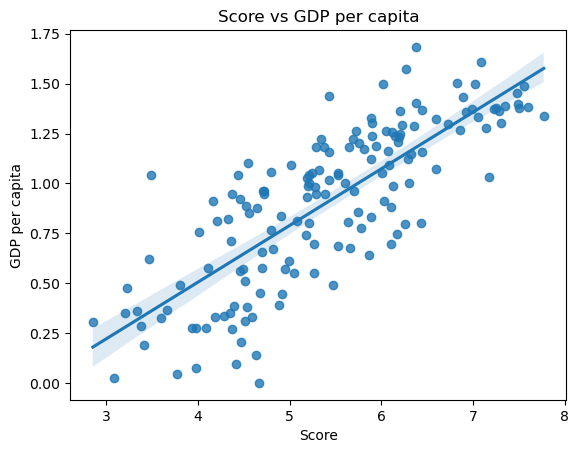

In [58]:
sns.regplot(data=df, x='Score', y= 'GDP per capita')
plt.title('Score vs GDP per capita')
plt.xlabel('Score')
plt.ylabel('GDP per capita')
plt.show()

Ми моделюватимемо цю залежність. Тобто незалежною змінною є `GDP per capita`, залежною `Score`. Судячи з діаграми розсіювання, залежність між цими двома змінними має добре описуватись лінійною моделлю.

## Розв'язання задачі лінійної регресії методом градієнтного спуску

Позначення:
- `X` - матриця ознак
- `y` - цільова змінна
- `theta` - вектор параметрів
- `alpha` - темп навчання (learning rate)

3. Реалізуємо формулу передбачення лінійної регресії у методі `predict`. Метод повертає передбачення. Для кожного спостереження з матриці ознак передбачення знаходимо за допомогою наступної формули:
$$x \in X, i \in [1,m], j : \\ \hat{y}_i = \theta_0 + \theta_1 x_1 + ... + \theta_n x_n = \theta^T x ,\\
\text{де m - кількість спостережень, } \\ 
\text{n - кількість ознак, } \\
x_0 = 1 \ \text{для всіх спостережень}.
$$

Передбачення всіх спостережень у матриці Х можемо знайти як множення матриці ознак на ваги.

In [59]:
def predict(X, theta):
    prediction = X @ theta
    return prediction

4. Доповнимо обчислення значення функції витрат.  
Метод `cost()` приймає вектор параметрів `theta`, матрицю наших ознак `X` та реальні значення цільової змінної `y`.


In [60]:
def cost(y_true, y_estimate):
    m = len(y_true)
    cost_value = (1./(2*m))*np.sum(np.power(y_true - y_estimate, 2))
    return cost_value

5. Ознайомимося з реалізацією методу `get_gradient()`, який повертає вектор часткових похідних функції витрат за кожним із параметрів лінійної регресії.
Доповнимо метод `gradient_descent()`, який дозволить реалізувати алгоритм градієтного спуску. Під час градієнтного спуcку оновлюємо параметри згідно з формулою:
$$
\text{для кожного} \ j \in [0, n]: \quad \theta_j := \theta_j - \alpha \frac{\partial}{\partial \theta_j}J(\theta), \\ 
\text{де n - кількість ознак}
$$
    Метод градієнтного спуску оновлює ваги (модель навчається) поки вони не перестануть змінюватися від ітерації до ітерації, тобто поки Евклідова відстань (звичайна відстань між веткорами, як у шкільній геометрії) між векторами ваг за останні дві ітерації не буде меншою за невелику константу (зазвичай позначається як $\epsilon$ (епсілон), ми встановимо $\epsilon=10^{-6}$).

В `gradient_descent()` заповнимо всі місця, де стоять три крапки. Використиємо реалізовані у попередніх завданнях методи `cost()` та `predict()`, і звичайно ж нам знадобиться метод `get_gradient()`.

In [62]:
def get_gradient(X, y, y_estimate):
    m = len(y)
    gradient = (1.0 / m) * X.T @ (y_estimate - y)
    return gradient

In [63]:
def gradient_descent(X, y, theta, learning_rate, eps, max_iterations):
    cost_history = []
    theta_history = []
    iterations = 1
    while True:
        y_estimate = predict(X, theta) # передбачення з поточними значеннями вагів
        gradient = get_gradient(X, y, y_estimate) # значення часткових похідних функції витрат з поточними значеннями ваг
        cost_value = cost(y, y_estimate) # значення функції витрат при поточних вагах
        cost_history.append(cost_value)
        new_theta = theta - learning_rate*gradient
        theta_history.append(new_theta)
        # Умова зупинки, описана в умові завдання
        if cost_value < eps:
            print("Алгоритм зійшовся.")
            break
            
        # Друга умова зупинки
        if iterations >= max_iterations:
            print("Досягнуто максимальної кількості ітерацій")
            break

        # Виводимо інформацію кожні 100 ітерацій
        if iterations % 100 == 0:
            print ("Ітерація: %d - Помилка на трейн даних: %.4f" % (iterations, cost_value))

        iterations += 1
        theta = new_theta
    return theta, cost_history, theta_history, iterations

Підготуємо дані.

In [66]:
X = df['GDP per capita'].values.reshape(-1,1)
y = df['Score'].values.reshape(-1,1)

6. Розділимо `X` та `y` на `train` і `test` підвиборки у співвідношенні 80/20. Запишемо результати у `X_train`, `y_train`, `X_test`, `y_test`.

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
print("X_train:",X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:", y_test.shape)

X_train: (124, 1) X_test: (32, 1) y_train: (124, 1) y_test: (32, 1)


7.Реалізуємо масштабування ознак із використанням `MinMaxScaler`. 

In [68]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

8. Додамо колонку з одиниць до масивів `X_train`, `X_test`.

In [69]:
X_train_scaled = np.concatenate((X_train_scaled, np.ones(X_train_scaled.shape)), axis=1)
X_test_scaled = np.hstack((X_test_scaled, np.ones(X_test_scaled.shape)))

9. Встановимо темп навчання рівний 0.01, точність епсілон рівний $10^{-6}$, кількість ітерацій дорівнює 20000 і запустимо градієнтний спуск на тренувальні дані, передавши всі необхідні параметри.

In [70]:
learning_rate = 0.01
max_iterations = 20000
epsilon = 10e-6

theta = np.random.randn(2,1)

theta, cost_history, theta_history, iterations = gradient_descent(X_train_scaled, y_train, theta, learning_rate, epsilon, max_iterations)

Ітерація: 100 - Помилка на трейн даних: 1.2907
Ітерація: 200 - Помилка на трейн даних: 0.3974
Ітерація: 300 - Помилка на трейн даних: 0.3230
Ітерація: 400 - Помилка на трейн даних: 0.3096
Ітерація: 500 - Помилка на трейн даних: 0.3013
Ітерація: 600 - Помилка на трейн даних: 0.2941
Ітерація: 700 - Помилка на трейн даних: 0.2875
Ітерація: 800 - Помилка на трейн даних: 0.2815
Ітерація: 900 - Помилка на трейн даних: 0.2761
Ітерація: 1000 - Помилка на трейн даних: 0.2711
Ітерація: 1100 - Помилка на трейн даних: 0.2666
Ітерація: 1200 - Помилка на трейн даних: 0.2625
Ітерація: 1300 - Помилка на трейн даних: 0.2588
Ітерація: 1400 - Помилка на трейн даних: 0.2554
Ітерація: 1500 - Помилка на трейн даних: 0.2523
Ітерація: 1600 - Помилка на трейн даних: 0.2495
Ітерація: 1700 - Помилка на трейн даних: 0.2469
Ітерація: 1800 - Помилка на трейн даних: 0.2446
Ітерація: 1900 - Помилка на трейн даних: 0.2425
Ітерація: 2000 - Помилка на трейн даних: 0.2405
Ітерація: 2100 - Помилка на трейн даних: 0.2388
І

10. Відобразимо на лінійному графіку значення змінної `cost_history`. 

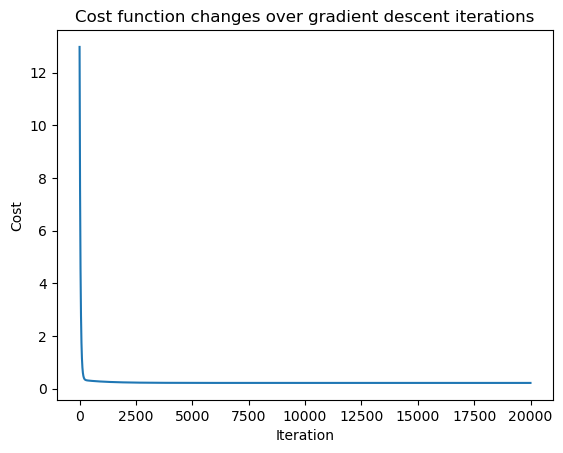

In [71]:
plt.plot(cost_history);
plt.xlabel('Iteration');
plt.ylabel('Cost');
plt.title("Cost function changes over gradient descent iterations");

Відобразимо лише перші 200 ітерацій. Схоже, що після них модель мало навчається. Можна було б застосувати техніку early stopping у даному випадку та зупинитися на деякій невеликій кількості ітерацій. Зазвичай ця техніка застосовується, щоб уникнути перенавчання. При цьому втрачається трохи точності на train set.

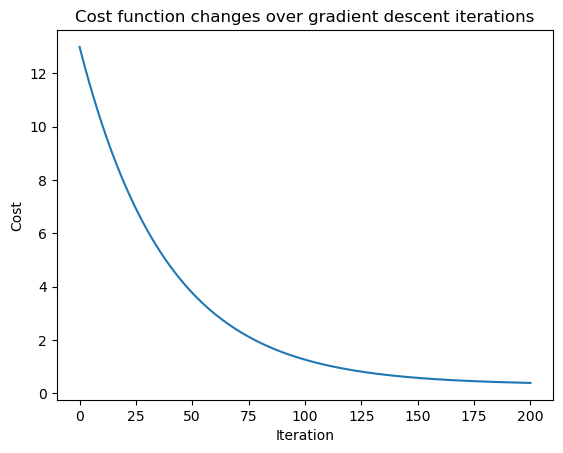

In [72]:
plt.plot(cost_history[:201]);
plt.xlabel('Iteration');
plt.ylabel('Cost');
plt.title("Cost function changes over gradient descent iterations");

Виведемо отримані параметри та останнє значення функції витрат.

In [74]:
print('Theta0: {:0.3f}, Theta1: {:0.3f}'.format(theta[0][-1],theta[1][-1]))
print('Final cost:  {:0.3f}'.format(cost_history[-1]))
print('Number of iterateions: {:d}'.format(iterations))

Theta0: 3.710, Theta1: 3.421
Final cost:  0.221
Number of iterateions: 20000


11. Знайдемо прогнози на `X_train_df`, `X_test_df` та порахуємо `mean_squared_error` помилку прогнозів обох підвибірках.

In [76]:
y_est_train = predict(X_train_scaled, theta)
y_est_test = predict(X_test_scaled, theta)
mse_train_hw = mean_squared_error(y_train, y_est_train)
mse_test_hw = mean_squared_error(y_test, y_est_test)
print(f"Train MSE is {mse_train_hw}, test MSE is {mse_test_hw}")

Train MSE is 0.4417211941105454, test MSE is 0.5079139151125764


12. Виведемо діаграму розсіювання ознак `Score` та `GDP per capita` та додамо лінію прогнозу моделі.

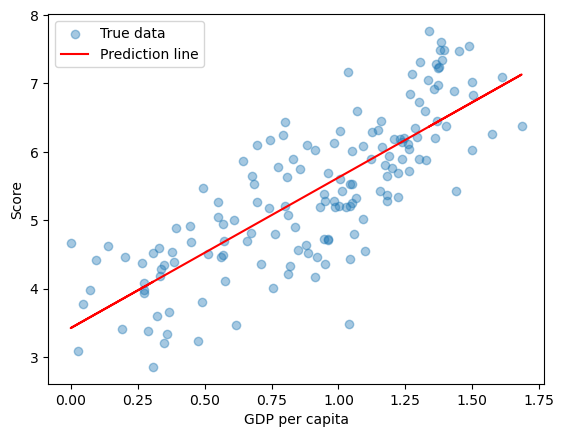

In [77]:
# scaling for whole data
X_scaled = scaler.transform(X)
# add column of ones
X_scaled = np.hstack((X_scaled, np.ones(X_scaled.shape)))
# prediction for whole data
y_pred = predict(X_scaled, theta)
# plot
plt.scatter(X, y, alpha=0.4, label='True data')
plt.plot(X, y_pred, "r", label='Prediction line')
plt.xlabel("GDP per capita")
plt.ylabel("Score")
plt.legend()

13. Навчимо лінійну регресію на наборі даних, що складається тільки з ознаки `GDP per capita`, але тепер використовуючи LinearRegression з sklearn.   

In [78]:
# ми могли би використати вже пораховані вище змінні, але давайте проробимо весь шлях спочатку, але тепер вже для моделі з sklearn
X = pd.DataFrame(df['GDP per capita'])
y = df['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

min_max_scaler = MinMaxScaler(feature_range=(0,1))
min_max_scaler.fit(X_train)
X_train_scaled = min_max_scaler.transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)
# стовпчик з одиниць додавати не треба, це вже реалізовано 
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

Порівняємо помилку на тестовій вибірці написаної лінійної регресії та зі sklearn. 

In [79]:
y_est_train = lr.predict(X_train_scaled)
y_est_test = lr.predict(X_test_scaled)
mse_train_lr = mean_squared_error(y_train, y_est_train)
mse_test_lr = mean_squared_error(y_test, y_est_test)
print(f"Train MSE: {mse_train_lr} sklearn vs {mse_train_hw} hand-written, test MSE: {mse_test_lr} sklearn vs {mse_test_hw} hand-written")

Train MSE: 0.4417211923118579 sklearn vs 0.4417211941105454 hand-written, test MSE: 0.5079112698997723 sklearn vs 0.5079139151125764 hand-written


Бачимо, що помилки практично однакові. 

14. Навчимо лінійну регресію на більшій кількості ознак і подивимося, чи вдасться покращити модель.

14.1 Навчимо лінійну регресію з sklearn використовуючи як набір ознак наступний: `GDP per capita`, `Social support`, `Healthy life expectancy`, `Freedom to make life choices`, `Generosity`, `Perceptions of corruption`

In [82]:
# спершу згадаємо допоміжні методи з лекції
def get_indices(X):
    train_id, test_id = train_test_split(X.index, test_size=test_size, shuffle=True, random_state=42)
    return train_id, test_id
    
def evaluate_model(model, X_train, X_test, y_train, y_test):
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  train_mse = mean_squared_error(y_train, y_train_pred)
  test_mse = mean_squared_error(y_test, y_test_pred)

  return train_mse, test_mse

In [84]:
feature_names = [
    'GDP per capita', 
    'Social support', 
    'Healthy life expectancy', 
    'Freedom to make life choices',
    'Generosity',
    'Perceptions of corruption'
]
target_col_name = 'Score'
test_size = 0.2

X = df[feature_names]
y = df[target_col_name]

train_id, test_id = get_indices(X)

min_max_scaler = MinMaxScaler(feature_range=(0,1))
min_max_scaler.fit(X.loc[train_id])
min_max_scaled = min_max_scaler.transform(X)
min_max_scaled_df = pd.DataFrame(min_max_scaled, columns=X.columns)

lr = LinearRegression()
lr.fit(min_max_scaled_df.loc[train_id], y.loc[train_id])

LinearRegression()

14.2 Виведемо помилку прогнозу на `train` та `test` вибірках. Порівняємо з результатом, отриманим під час навчання однією ознакою. 

In [85]:
mse_train_mf, mse_test_mf = evaluate_model(lr, min_max_scaled_df.loc[train_id], min_max_scaled_df.loc[test_id], y.loc[train_id], y.loc[test_id])
print(f"Multiple linear regression train MSE is {mse_train_mf}, test MSE is {mse_test_mf}")

Multiple linear regression train MSE is 0.23646992155921964, test MSE is 0.4144641383528353


14.3 Виведемо коефіцієнти моделі і визначимо, які ознаки мають найбільші коефіцієнти по модулю, що стоять перед ними.

In [86]:
importance = pd.DataFrame({"features": X.columns, "coefficient": np.abs(lr.coef_)}).sort_values("coefficient", ascending=False)
importance

,features,coefficient
1,Social support,2.001295
0,GDP per capita,1.264207
2,Healthy life expectancy,1.062208
3,Freedom to make life choices,0.940072
5,Perceptions of corruption,0.503931
4,Generosity,0.153034


15. Навчимо модель поліноміальної регресії зі ступенем 2 на тих самих даних, що й у попередньому пункті. Використаємо у процесі навчання `PolynomialFeatures`. Дослідимо метрики якості на трейні та тест датасетах. 

In [87]:
# створюємо обʼєкт 
poly = PolynomialFeatures(degree=2, include_bias=False)
# для тренувальної вибірки можемо використовувати одразу fit_transform
X_poly_train = poly.fit_transform(min_max_scaled_df.loc[train_id])
X_poly_test = poly.transform(min_max_scaled_df.loc[test_id])

# тренуємо лінійну регресію на поліноміальних фічах
lr_poly = LinearRegression()
lr_poly.fit(X_poly_train, y.loc[train_id])

# рахуємо метрики якості
mse_train_poly, mse_test_poly = evaluate_model(lr_poly, X_poly_train, X_poly_test, y.loc[train_id], y.loc[test_id])
print(f"Polinomial  regression train MSE is {mse_train_poly}, test MSE is {mse_test_poly}")

Polinomial  regression train MSE is 0.14675898592009984, test MSE is 0.37894713847097816


Присутній overfit

16. Зробимо пайплайн із кроками `MinMaxScaler`, `PolynomialFeatures` та `ElasticNet`. 

In [88]:
degree = 2
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(degree=degree)),
    ('model', ElasticNet())
])
pipeline.fit(X.loc[train_id], y.loc[train_id])
# рахуємо метрики якості
mse_train_pipe, mse_test_pipe = evaluate_model(pipeline, X.loc[train_id], X.loc[test_id], y.loc[train_id], y.loc[test_id])
print(f"Polinomial  regression train MSE is {mse_train_pipe}, test MSE is {mse_test_pipe}")

Polinomial  regression train MSE is 1.2794603680411027, test MSE is 1.0444315956685744


In [89]:
# а тепер порівняємо MSE для моделей, що тренували вище
metrics = pd.DataFrame({
    "model":["hand-written lr", "simple lr", "multiple lr", "poly lr"],
    "train_mse": [mse_train_hw, mse_train_lr, mse_train_mf, mse_train_poly],
    "test_mse": [mse_test_hw, mse_test_lr, mse_test_mf, mse_test_poly]
    })
metrics.style.background_gradient()

,model,train_mse,test_mse
0,hand-written lr,0.441721,0.507914
1,simple lr,0.441721,0.507911
2,multiple lr,0.236470,0.414464
3,poly lr,0.146759,0.378947


Висновок: найнижчі помилки для тренувальної і тестової вибірки має поліноміальна регресія.Також бачимо, що різниця між тестовою і тренувальною MSE поліноміальної регресії і регресії на багатьох фічах досить велика. Це може свідчити про перенавчання. Тут в нагоді стане регуляризація.